In [50]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics


%matplotlib inline

In [51]:
# data
fashionBIG = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/SKP_fashionBIG.csv")
fashionBIG.head()

,age,income,months_subbed,upgrade
0,22,55.89,14,0
1,32,86.03,57,0
2,38,49.22,37,1
3,14,92.71,51,1
4,33,94.06,37,0


In [52]:
predictors = ["age", "income", "months_subbed"]

X = fashionBIG[predictors]
y = fashionBIG["upgrade"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# zscore
z = StandardScaler()
z.fit(X_train)

X_train[predictors] = z.transform(X_train)
X_test[predictors] = z.transform(X_test)

In [53]:
#create
myLogit = LogisticRegression()

In [54]:
#fit
myLogit.fit(X_train, y_train)

LogisticRegression()

In [55]:
#predict
predictedVals = myLogit.predict(X_test)
predictedProbs = myLogit.predict_proba(X_test)

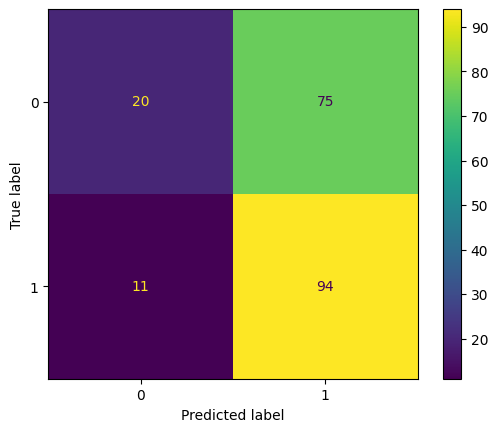

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, myLogit.predict(X_test))

In [57]:
# metrics
print("Accuracy: ", accuracy_score(y_test, predictedVals))
print("F1 Score: ", f1_score(y_test, predictedVals))
print("Recall: ", recall_score(y_test, predictedVals))
print("Precision: ", precision_score(y_test, predictedVals))

Accuracy:  0.57
F1 Score:  0.6861313868613138
Recall:  0.8952380952380953
Precision:  0.5562130177514792


In [58]:
# metrics
print("Accuracy: ", accuracy_score(y_train, myLogit.predict(X_train)))
print("F1 Score: ", f1_score(y_train, myLogit.predict(X_train)))
print("Recall: ", recall_score(y_train, myLogit.predict(X_train)))
print("Precision: ", precision_score(y_train, myLogit.predict(X_train)))

Accuracy:  0.585
F1 Score:  0.7152658662092625
Recall:  0.879746835443038
Precision:  0.6026011560693642


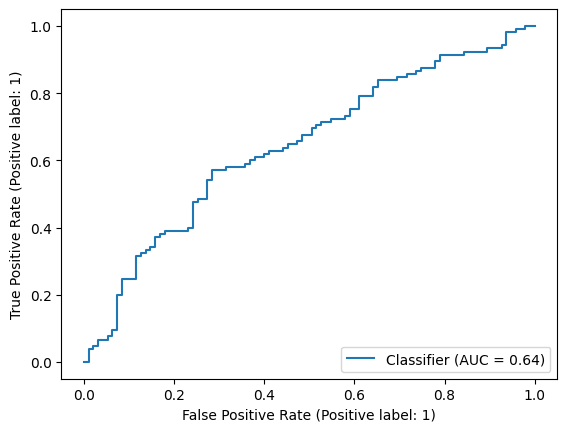

In [59]:
RocCurveDisplay.from_predictions(y_test, myLogit.predict_proba(X_test)[:,1])

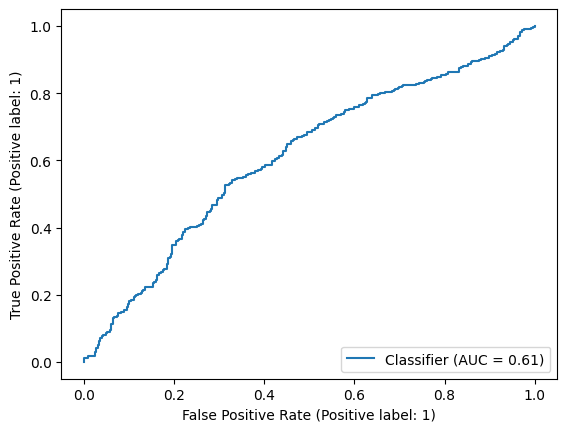

In [60]:
RocCurveDisplay.from_predictions(y_train, myLogit.predict_proba(X_train)[:,1])

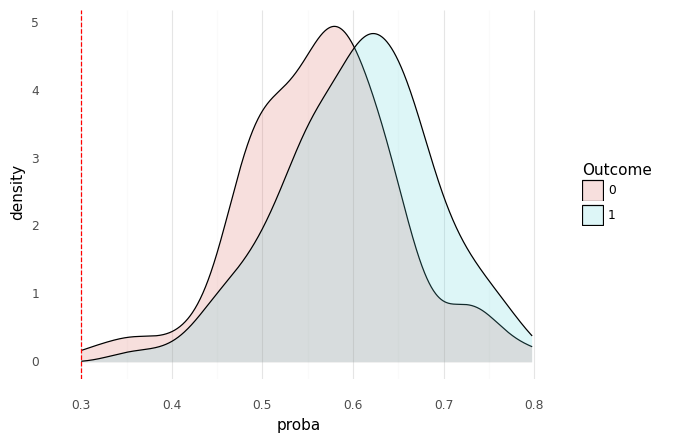

<ggplot: (8687507217910)>

In [61]:
# Fun Plots
overlap_plot_df = pd.DataFrame({"proba": predictedProbs[:,1],
                                "outcome": y_test})

(ggplot(overlap_plot_df, aes(x = "proba", y = 1, fill = "factor(outcome)")) + geom_point() +
 theme_minimal() + ylim(0,2) +
 scale_fill_discrete(name = "Outcome") +
 theme(panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()))

thresh = 0.3
(ggplot(overlap_plot_df, aes(x = "proba",  fill = "factor(outcome)")) + geom_density(alpha = 0.2) +
 theme_minimal() +
 scale_fill_discrete(name = "Outcome") +
 theme(panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()) +
 geom_vline(xintercept = thresh, color = "red", linetype = "dashed"))

<img src="https://drive.google.com/uc?export=view&id=1n-Pg6y8wD-UM05kPyVKorbmteMpHdmcG"/>


## Calibration Plot

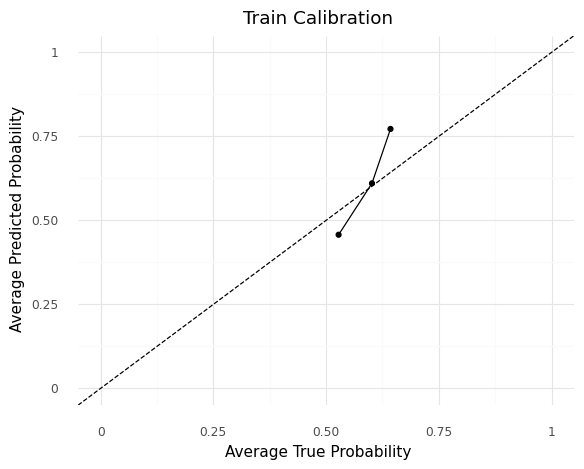

<ggplot: (8687507164458)>

In [62]:
# calculate actual and predicted probs
nbins = 4
prob_true, prob_pred = calibration_curve(y_train, myLogit.predict_proba(X_train)[:,1], n_bins=nbins)

# put in data frame
df_all = pd.DataFrame({
                            "pred": prob_pred,
                            "true": prob_true,

                        })

# plot
(ggplot(df_all,
                   aes(y = "pred", x = "true")) +
                   geom_line() +
                   geom_point() +
                   geom_abline(slope = 1, intercept = 0, linetype = "dashed") + # perfect calibration
                   labs(x = "Average True Probability",
                        y = "Average Predicted Probability",
                        title = "Train Calibration") +
                   ylim([0,1]) +
                   xlim([0,1]) +
                   theme_minimal())


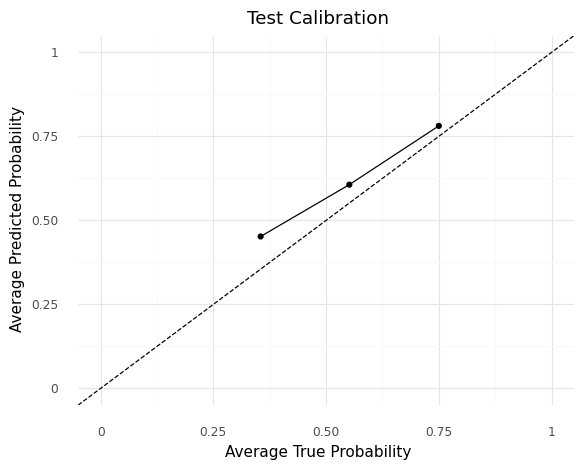

<ggplot: (8687507228549)>

In [63]:
# calculate actual and predicted probs
nbins = 4
prob_true, prob_pred = calibration_curve(y_test, myLogit.predict_proba(X_test)[:,1], n_bins=nbins)

# put in data frame
df_all = pd.DataFrame({
                            "pred": prob_pred,
                            "true": prob_true,

                        })

# plot
(ggplot(df_all,
                   aes(y = "pred", x = "true")) +
                   geom_line() +
                   geom_point() +
                   geom_abline(slope = 1, intercept = 0, linetype = "dashed") + # perfect calibration
                   labs(x = "Average True Probability",
                        y = "Average Predicted Probability",
                        title = "Test Calibration") +
                   ylim([0,1]) +
                   xlim([0,1]) +
                   theme_minimal())


## Predict new Data

In [64]:
fashionNEW = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/SKP_fashionNEW.csv")

Xnew = fashionNEW[predictors]
Xnew[predictors] = z.transform(Xnew)



In [65]:
# predict
y_pred_new = myLogit.predict(Xnew)

In [66]:
# acc
print("Accuracy: ", accuracy_score(fashionNEW["upgrade"],y_pred_new))

Accuracy:  0.593


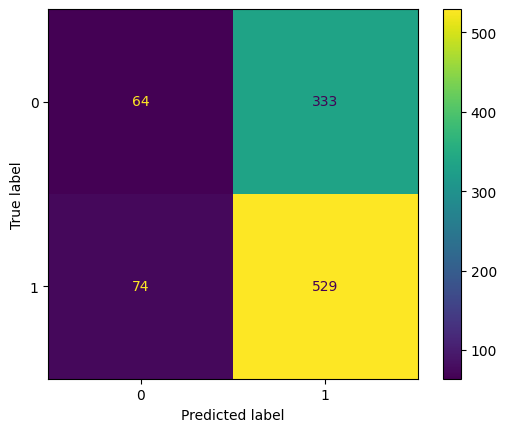

In [67]:
# confusion matrix
ConfusionMatrixDisplay.from_predictions(fashionNEW["upgrade"], y_pred_new)

## LR with Cross Validation

In [68]:
# Kfold

X = fashionBIG[["age","income","months_subbed"]]
y = fashionBIG["upgrade"]

# create k-fold object
kf = KFold(n_splits = 5)

#create model
lr = LogisticRegression()

#create empty list to store accuracy for each fold
acc_train = []
acc_test = []

roc_train = []
roc_test = []

In [69]:
# Use a for loop to loop through each fold and train a model, then add the accuracy to acc.

for train_indices, test_indices in kf.split(X):
    # Get your train/test for this fold
    X_train = X.iloc[train_indices]
    X_test  = X.iloc[test_indices]
    y_train = y[train_indices]
    y_test  = y[test_indices]

    # z score
    z = StandardScaler()
    X_train[predictors] = z.fit_transform(X_train)
    X_test[predictors] = z.transform(X_test)

    # model
    lr.fit(X_train, y_train)


    # record accuracy
    acc_train.append(accuracy_score(y_train, lr.predict(X_train)))
    acc_test.append(accuracy_score(y_test, lr.predict(X_test)))

    roc_train.append(roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
    roc_test.append(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))



#print overall acc
print(acc_train)
print(np.mean(acc_train))

print(acc_test)
print(np.mean(acc_test))

print(np.round(roc_train,2))
print(np.mean(roc_train))

print(np.round(roc_test,2))
print(np.mean(roc_test))

[0.595, 0.59875, 0.60125, 0.58125, 0.59125]
0.5934999999999999
[0.58, 0.605, 0.54, 0.565, 0.645]
0.587
[0.62 0.63 0.62 0.6  0.62]
0.6176157294258144
[0.61 0.57 0.59 0.67 0.62]
0.6119575976631173
